# Mode collapse jelenség és Regularizációs módszerek


A Mode collapse jelenség alatt a tanulás során bekövetkező anomáliát értjük, amely hatására a Generátor a látens tér bármely pontjára ugyanolyan kimeneti képet generál. A képek között minimális változatosság ugyan megfigyelhető, ugyanakkor az is látható, hogy a képeken igen hasonló formák jelennek meg.

Ez a jelenség valójában tekinthető egyfajta overfitting-nek is, vagyis túltanulásnak. Viszont a mode-collapse elnevezés találóbb, hiszen amikor ez bekövetkezik, akkor a további tanítási lépések során úgy tűnhet, hogy stablian tűnő modell hirtelen összeomlott volna.
A mode-collapse fellépése esetén a model további tanítása során minden egyes epoch-al változik a mode, vagyis az előzőtől eltérő kép jelenik meg a kimeneten (szintén minden egyes mintavételezett pontra hasonló). Mivel a diszkriminátor a mini-batch minden egyes bemenetét egymástól függetlenül dolgozza fel, így a gradienseiben sem jelenik meg olyan információ, amely a generátort változatosabb képek generálására bíztatná. A mode collapse esetén a diszkriminátor egyetlen pontot képes csak valódi adatnak tekinteni, majd minden egyes frissítéssel a pont elmozdul, ezzel magyarázható, hogy az összeomlás után tanítva minden egyes iterációval változik a "mode".
(salimans2016improved)
Vagyis a GAN modellünk használhatatlanná válik.

"Helvetica scenario"

In [1]:
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math

2022-03-21 15:27:38.711334: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-21 15:27:38.711370: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


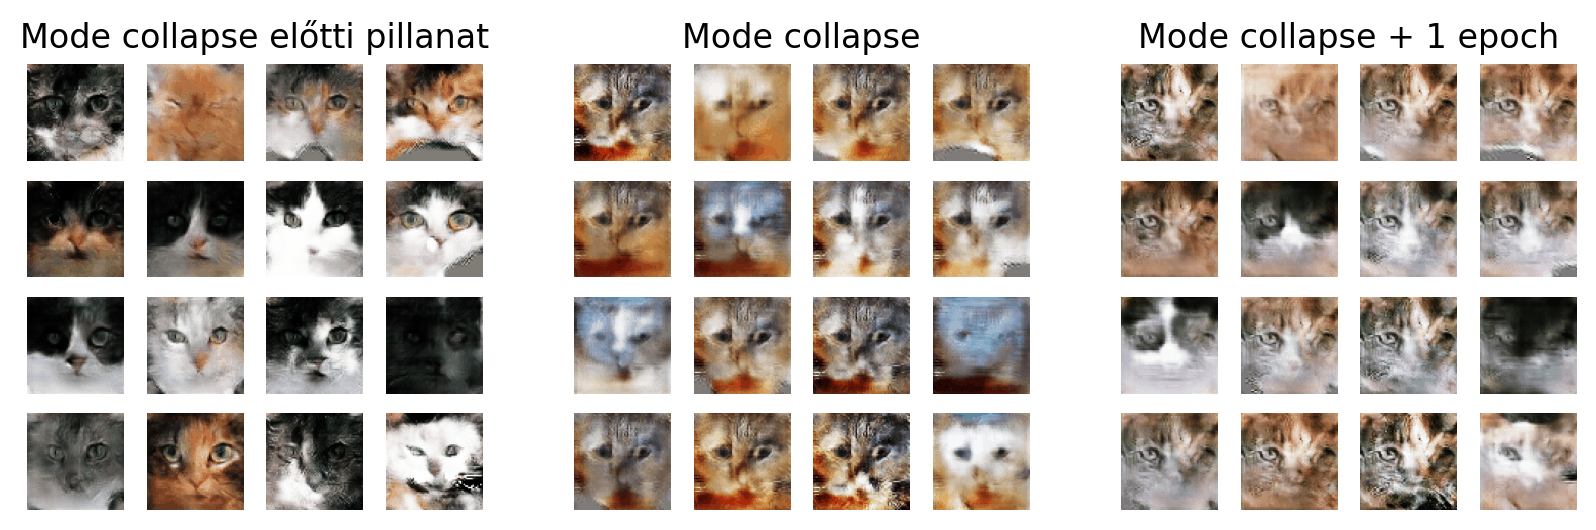

In [2]:
before_collapse = mpimg.imread('./images/before-collapse.png')
collapse01 = mpimg.imread('./images/collapse01.png')
collapse02 = mpimg.imread('./images/collapse02.png')

fig, axes = plt.subplots(figsize=(10, 3), nrows=1, ncols=3, dpi=200)

axes[0].set_title("Mode collapse előtti pillanat")
axes[0].axis('off')
axes[0].imshow(before_collapse, interpolation='none')

axes[1].set_title("Mode collapse")
axes[1].axis('off')
axes[1].imshow(collapse01, interpolation='none')

axes[2].set_title("Mode collapse + 1 epoch")
axes[2].axis('off')
axes[2].imshow(collapse02, interpolation='none')

plt.show()

A tanítás közben felléphetnek lokális mode-collapse-ok is, amelyek a látens-tér egyes tartományaiban alakulhat ki (Stackgan2-ben vizsgálták ezt).

Egyes cikkekben az összeomlásig tanítják a felvázolt modelleket és az összeomlás előtti állapotokra állítják vissza a hálózat súlyait a használathoz (BigGAN csinált ilyet, meg még más is, de meg kell keresnem.).

TODO: Mode collapse okok pontosabb leírása, detektálási technikák megnézése

A GAN tanítása során nehézségekbe ütközhetünk. Legrosszabb esetben nem is kezd el konvergálni a generátor kimenete a tanítóminta képeihez, viszont abban az esetben gyanakodhatunk, hogy a modellünk nem lett helyesen felépítve. Amennyiben mégis elkezd fejlődni a modell és nem csak zaj jelenik meg a kimeneten az egyes tanítólépések után, de bizonyos számú epoch után mode collapse lép fel, úgy fontolóra vehetjük a következő regularizációs technikákat.

TODO: Technikákhoz mérések, vagy kimenetek, hogy egy adott datasetre hogyan teljesít egy adott modell ha alkalmazzuk az alábbi technikákat vagy azok kombinációit!
A mérésekhez pl lehetne minden epochra mérni az IS + FID score-t is, továbbá példaképeket is lehetne mellékelni

## Label-smoothing

A label-smoothing az egyik legegyszerűbb regularizációs trükk, amely a neurális hálók overfitting problémáját kívánja kiküszöbölni. Ezen módszer alkalmazásához nem szükséges módosítanunk az architektúránkat, csupán a hibafüggvényt, így ez egy egészen egyszerűen implementálható technika. GAN esetében a diszkriminátor hibafüggvényét szokás módosítani oly módon, hogy a bináris keresztentrópia számolás során a valós bemeneti képek 1-es címke helyett valamennyivel alacsonyabb értéket, például 0.9-et kapnak. Ezzel a beállítással a diszkriminátor kevésbé lesz hajlamos a túlzott magabiztosságra a valós bemeneti képek esetén, teret adva a generátor fejlődésének.

A regularizációs technikákban megfigyelhető néhány esetben egy kicsi ellentmondásosság is, például egyes technikák a diszkriminátort hátráltatják, míg mások a generátor dolgát nehezítik meg. Természetesen a problémától függ, hogy melyik módszer alkalmazható egy adott modellnél.

In [3]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.constant(np.full(real_output.shape, 0.9)), real_output)
    fake_loss = cross_entropy(tf.constant(np.full(fake_output.shape, 0)), fake_output)
    
    total_loss = real_loss + fake_loss
    return total_loss

## Megfelelő inicializációs stratégia

A mély neurális hálózatoknál igen gyakran előforduló probléma az úgynevezett exploding vagy éppen a vanishing gradiensek jelensége, amelyet gyakran csupán instabil gradienseknek is szokás nevezni.
A tanítás forward-propagation stádiumában a hálózat kimenetén megfigyelhető túl magas vagy éppen túl alacsony értékek a hibafüggvény meghatározásánál is szélsőséges értékeket okozhatnak.
A backpropagation stádiumában az output rétegtől haladunk az input felé, amely során kiszámolásra kerülnek a gradiensek a hálózat minden egyes paraméterének függvényében. Majd Gradient Descent vagy ahhoz hasonló algoritmus segítségével frissülnek a hálózat paraméterei. Mindkét irányban fontos lenne elkerülni az esetleges kilengéseket, hogy a tanítás stabilitását elősegítsük.
Az olyan hálózatoknál, amelyekben több rejtett réteg is található, az instabil gradiensek jelensége még inkább érvényesül. A backpropagation során az input réteg felé haladva a gradiensek hajlamosak lehetnek igen kis értékekre zsugorodni. Ilyen esetben az alacsonyabb rétegek rendszerint lassabban fognak tanulni, amely szintén komoly problémát jelent.
A hálózat rétegeiben megtalálható neuronok az előző rétegek neuronjaitól függenek, illetve a kimenetük a következő réteg neuronjait is befolyásolja. Egy esetlegesen fellépő túl magas vagy túl alacsony kilengés a kimeneti értékekben komoly hatással lehet a teljes hálózatra.

TODO: Mátrix-szorzás, forward és backpropagation formális leírása szépen.

Az instabil gradiensek megelőzésére az egyik irány a neuronok inicializációs stratégiájának megválasztása.
Az évek során több ajánlás is érkezett, a különböző felépítésű hálózatokra különböző technikák váltak be.

Kiemelnék két inicializációs technikát, a Glorot és a He stratégiákat, amelyek széleskörűen alkalmazhatónak bizonyultak.
A kezdőértékek generálásához figyelembe veszik a rétegek be- és kimeneti kapcsolatainak számát is, amelyet $fan_{in}$ és $fan_{out}$-nak is nevezhetünk és azok átlagát használják fel a számoláshoz.

$$fan_{avg} = \frac{fan_{in} + fan_{out}}{2}$$

A **Glorot/Xavier** inicializációs stratégia normális és egyenletes eloszlásra is számolható.
Normális eloszlás esetén a várható értéket $m = 0$-ra kell választani, a szórásnégyzet pedig: $ \sigma^2 = \frac{1}{fan_{avg}} $.

$$ \mathcal{N}(0, \frac{1}{fan_{avg}}) $$

Egyenletes eloszlás esetén $\pm r$ között,

$$r = \sqrt{\frac{3}{fan_{avg}}}$$

$$ \mathcal{U}\left[-r, r\right] $$

Ezen inicializációs stratégia a tangens-hiperbolikusz, logisztikus és szoftmax aktivációs függvényekkel rendelkező rétegekben használatosak. 


A **He/Kaiming** inicializáció hasonló megközelítést alkalmaz,
Normális eloszlásra:

$$ \mathcal{N}(0, \frac{2}{fan_{in}}) $$

Egyenletes eloszlásra:

$$r = \sqrt{3\frac{2}{fan_{in}}}$$

$$ \mathcal{U}\left[-r, r\right] $$

Ezen inicializációs stratégia pedig a ReLU aktivációs függvénnyek családjával rendelkező rétegekben ajánlott használni.


A Keras a Glorot inicializálást használja alapértelmezetten.


TODO: Egyszerű példákkal szemléltetve az eredményeket.

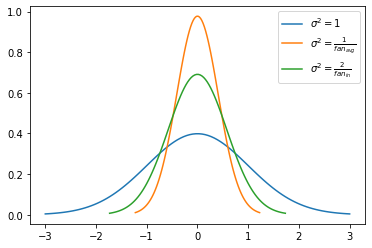

In [4]:
def plot_normal(mu, variance, label):
    sigma = math.sqrt(variance)
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    plt.plot(x, stats.norm.pdf(x, mu, sigma), label=label)
    

fan_in = 6
fan_out = 6
    
plot_normal(0, 1, r'$\sigma^2 = 1$')
plot_normal(0, 1/((fan_in + fan_out)/2), r'$\sigma^2 = \frac{1}{fan_{avg}}$')
plot_normal(0, 2/fan_in, r'$\sigma^2 = \frac{2}{fan_{in}}$')
plt.legend(loc=0)
plt.show()

In [5]:
def calc_forwardprop(input_value, hidden_layers, activation, initializer):
    visible = keras.layers.Input(shape=[1])
    hidden = visible
    for i in range(hidden_layers):
        hidden = keras.layers.Dense(512, activation=activation, kernel_initializer=initializer)(hidden)
    model = keras.models.Model(inputs=visible, outputs=[hidden])

    output = model(input_value, training=False)
    mean = "{:.20f}".format(output.numpy().mean())
    std = "{:.20f}".format(output.numpy().std())
    print(f"A model with {hidden_layers} hidden layers, {activation} activation, {initializer} initializer")
    print(f"Mean: {mean}")
    print(f"Std: {std}\n")

hidden_layers = 20
input_value = tf.constant([1.0])
calc_forwardprop(input_value, hidden_layers, "relu", "glorot_normal")
calc_forwardprop(input_value, hidden_layers, "relu", "random_normal")
calc_forwardprop(input_value, hidden_layers, "relu", "he_normal")


2022-03-21 15:27:42.537580: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-21 15:27:42.537625: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-21 15:27:42.537662: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Inspiron-5558): /proc/driver/nvidia/version does not exist
2022-03-21 15:27:42.538174: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


A model with 20 hidden layers, relu activation, glorot_normal initializer
Mean: 0.00001989825250348076
Std: 0.00002785736432997510

A model with 20 hidden layers, relu activation, random_normal initializer
Mean: 0.00024093153479043394
Std: 0.00036517390981316566

A model with 20 hidden layers, relu activation, he_normal initializer
Mean: 0.82644295692443847656
Std: 1.15801000595092773438



## Batch Normalization

Az instabil gradiensek problémája a tanítás során is jelentkezhet, a megfelelő inicializációs stratégia nem garantálja a teljes stabilitást, csupán egy kezdeti optimális állapotot biztosít a modellnek.
Az input adatok standardizálása áll a Batch Normalization technika mögött, amelyet a rétegek között vagy a rétegek aktivációs függvénye előtt ajánlott megtenni. A Batch Normalization technika alkalmazásához tehát minimálisan módosítanunk kell a meglévő modelljeink architektúráját. Viszont úgy figyeltem meg, hogy ezen technika alkalmazása teljesen empirikus módon történik és nincsen egy általánosan elfogadott módszer arra sem, hogy pontosan hol kell elhelyezni a réteget (az aktivációs függvények előtt vagy után vagy mindkét helyen bigGAN esetében mindenhova rakták, a többit meg kell néznem). A GAN esetében a kezdeti próbálkozásban csupán a diszkriminátorban (tényleg így van?) helyezték el a rétegeket (melyik cikkekben láttam ezt?), majd a generátorban is alkalmazásra került. Kétségtelen, hogy a technika alkalmazásával stabilabb tanítást eredményez és széleskörűen alkalmazható a mély neurális hálózatokban.

A Batch Normalization technika zero-centerezi és normalizálja az inputokat, majd skálázza és shifteli az eredményeket. Vagyis két tanulható paramétervektor jelenik meg rétegenként a modellünkben, a skálázásra és shiftelés műveletre. A technika neve a mini-batch tanítási stratégiából adódik, vagyis amikor egy tanítási lépést nem a teljes dataset-re hajtunk végre, csupán egy annak kisebb szeletére. A Batch Normalization zero-centerező és normalizáló lépéséhez az algoritmusnak meg kell becsülnie az aktuális bemeneti mini-batch várható értékét és szórását. Ezt a becslést csupán tanítási időben tudja megtenni az algoritmus, hiszen olyankor rendelkezésére áll a teljes mini-batch. Viszont tesztelésnél, amikor csupán egy-egy tesztadatot lát a modell, úgy nem hagyatkozhatunk a becsült várhatóértékre és szórásra. A Keras-ban található implementáció a tanulás során mozgóátlaggal vezeti a várhatóértékeket és a szórásokat. Ez további két paramétert jelent, amelyeket a modell a tanulási folyamat során fog meghatározni a már említett módon, viszont a backpropagation során nem kerülnek finomhangolásra, csupán tesztidőben kerülnek felhasználásra ezek az értékek.

Az algoritmus működése a következőképpen írható fel a hands-on könyv alapján saját jelölésekhez igazítva:

Legyen $m$ a minibatch elemszáma $m \in \mathbb{N}, 0 > m \ge n$, ahol $n$ a dataset elemszáma

$m = \{x_1, x_2, \ldots, x_m \}$ 

1. Határozzuk meg a várható értékeket a mini-batch elemeire
$$ \vec{\mu} = \frac{1}{m} \sum_{i=1}^{m} x_i $$

2. Határozzuk meg a szórásnégyzeteket a minibatch elemeire
$$ \sigma^2 = \frac{1}{m} \sum_{i=1}^{m} (x_i - \mu)^2 $$

3. Zero-centerezzük és normalizáljuk az inputokat. $\varepsilon$ egy kicsi szám (általában $10^{-5}$), ami a 0-val való osztás elkerülése érdekében van jelen
$$ \hat{x_i} = \frac{x_i - \mu}{\sqrt{\sigma^2 + \varepsilon}} $$

4. Skálázzuk a $\gamma$ és shifteljük $\beta$ paraméterekkel az inputokat
$$ z_i = \gamma \otimes \hat{x_i} + \beta$$

Az algoritmus kimenete a $z_i$.

(sok GAN architektúrában megfigyelhető (melyek azok?) de pl a ProGAN ehelyett Pixelwise-normalization-t használ a generátorban

In [6]:
visible = keras.layers.Input(shape=[1])
hidden = keras.layers.BatchNormalization()(visible)
model = keras.models.Model(inputs=visible, outputs=[hidden])

model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1)                 4         
Total params: 4
Trainable params: 2
Non-trainable params: 2
_________________________________________________________________


A fenti kis példa egy olyan hálózatot definiál, amelyben egyetlen Batch Normalization réteg található. Mint látható valóban 4 paraméterrel rendelkezik a réteg, viszont azokból csak kettő tanítható, amelyek a $\gamma$ skálázó és $\beta$ shiftelő paraméterek. A másik két paraméter a már említett mozgó-átlag és szórás, amelyeket a Keras a tanítás során számol ki.

In [7]:
[(var.name, var.trainable) for var in model.layers[1].variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

## Spectral Normalization
(Ennek használata megengedi a nagyobb minibatch-méret használatát, hogy minél változatosabb képeket tudjon generálni a generátor. ennek utána kell néznem, hogy pontosan hogyan működik)

- Lipschitz constant az egyetlen hyper-paraméter
- Egyszerű implementáció

While input based regularizations allow for relatively easy formulations based on samples, they also
suffer from the fact that, they cannot impose regularization on the space outside of the supports of
the generator and data distributions without introducing somewhat heuristic means.


$$ \sigma(A) := \max_{\boldsymbol{h}:\boldsymbol{h}\neq 0} \frac{\|A\boldsymbol{h}\|_2}{\|\boldsymbol{h}\|} = \max_{\|\boldsymbol{h}\|_2 \leq 1} \|A\boldsymbol{h}\|_2$$

A Spectral Normalization normalizálja a $W$ súlymátrix spectral normálisát oly módon, hogy az kielégítse a Lipschitz megkötést $\sigma(W) = 1$.



Lipschitz megkötés 3 módon:

Wasserstein GAN -> a critic-nek 1 folytonos Lipschitz térhez kellett tartoznia
Cliping the weights
Gradient penalty és a spectral norm

Optimális diszkriminátor: pdata(x)/(pdata(x)+Pg(x)


TODO: Mindezekről írni

## Experience replay
(A tanulás során a korábbi kimenetek egy bufferben való tárolása és időközönként a modellnek újra megmutatjuk az eredményeket. Biológiai ok: alvás és álmodás fontossága. A régi megtanult feature-ök megőrzését segíti elő)

## Mini-batch discrimination

A mode collapse jelenség egyik ismertetőjegye amikor a generáto kimenetén közel azonos képek figyelhetők meg. A diszkriminátor minden inputját függetlenül vizsgálja, így a tanulás során lényegében nem használja ki azt a lehetőséget, hogy mini-batch-okon tanítjuk. A már említett Batch-Normalization technika természetesen nem működne független bemenetekre, viszont a diszkriminátor döntése nem függ az egyidőben beadott inputoktól. Így a diszkriminátor az érkező mode collapse pillanatát nem képes érzékelni.
Erre a problémára kíván javaslatot tenni a Mini-batch discrimination technika, amelynek alapötlete az, hogy a diszkriminátor a döntéseit több bemenet kombinációiból határozza meg.
A cikkben felvetett implementációja az egymáshoz közeli képek detektálására irányul. Ha az inputként kapott mini-batch képei közel állnak egymáshoz, akkor az egész mini-batch-ot hamis címkével kell ellátni. Ezáltal az összeomlás egészen jól detektálható és ezen technika arra kényszeríti a generátort, hogy minél változatosabb képeket generáljon a hibafüggvényének minimalizálása érdekében.

A diszkriminátor egy belső rétegének kimenete egy transzfromáló tensoron keresztül mátrixokat alkot és ezeknek nézi meg a L1 normáját...



a belső feature-öket így jelöli: $f(x_i) \in \mathbb{R}^A $

a $T \in \mathbb{R}^{A \times B \times C} $ # A $B,C$ hogyan kerül meghatározásra?

amiből lesznek mátrixok $M_i \in \mathbb{R}^{B \times C}$

$$ c_b(x_i, x_j) = \exp(- \|M_{i,b} - M_{j,b}\|_{L_1}) \in \mathbb{R} $$

L1 norma - Minél kisebb annál hasonlóbbak az inputok


De a cikkben a feature matching-et jobbnak találták, viszont a későbbiekben pl a progan is használta a minimatch-ot??


## Two Time-Scale Update Rule (TTUR)

Ezen technikát szintén meg lehet valósítani architektúrális változtatás nélkül, csupán az Adam optimalizáló eljárás egyik paraméterét kell megfelelően beállítani az implementációjához.
Heusel et al. cikkjében mérésekkel alátámaztották, hogy ha az Adam optimalizáló módszert választjuk a GAN tanításához és a learning rate paramétert a generatároban és a diszkriminátorban különbözőre állítjuk, úgy a modell gyorsabban és stabilabban fog konvergálni a lokális optimumokhoz.


0.0001
0.0004

(különböző learning rate a generátorban és a diszkriminátorban)